# [FMA: A Dataset For Music Analysis](https://github.com/mdeff/fma)

Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Usage

1. Go through the [paper] to understand what the data is about.
1. Download some datasets from <https://github.com/mdeff/fma>.
1. Uncompress the archives, e.g. with `unzip fma_small.zip`.
1. Load and play with the data in this notebook.

[paper]: https://arxiv.org/abs/1612.01840

In [79]:
%matplotlib inline

import os

import warnings
warnings.filterwarnings('ignore')

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
import ast
from sklearn import svm

import utils

plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 53), (163, 4), (106574, 518), (13129, 249))

## 1 Metadata

The metadata table, a CSV file in the `fma_metadata.zip` archive, is composed of many colums:
1. The index is the ID of the song, taken from the website, used as the name of the audio file.
2. Per-track, per-album and per-artist metadata from the Free Music Archive website.
3. Two columns to indicate the subset (small, medium, large) and the split (training, validation, test).

In [3]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())

bit_rate  comments   composer        date_created date_recorded  \
track_id                                                                    
2           256000         0        NaN 2008-11-26 01:48:12    2008-11-26   
3           256000         0        NaN 2008-11-26 01:48:14    2008-11-26   
5           256000         0        NaN 2008-11-26 01:48:20    2008-11-26   
10          192000         0  Kurt Vile 2008-11-25 17:49:06    2008-11-26   
20          256000         0        NaN 2008-11-26 01:48:56    2008-01-01   

          duration  favorites genre_top     genres         genres_all  \
track_id                                                                
2              168          2   Hip-Hop       [21]               [21]   
3              237          1   Hip-Hop       [21]               [21]   
5              206          6   Hip-Hop       [21]               [21]   
10             161        178       Pop       [10]               [10]   
20             311          0       NaN  [76, 103]  [17, 10, 76, 103]   

         information  interest language_code  \
track_id                                       
2                NaN      4656            en   
3                NaN      1470            en   
5                NaN      1933            en   
10               NaN     54881            en   
20               NaN       978            en   

                                                    license  listens lyricist  \
track_id                                                                        
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...     1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...      514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...     1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...    50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...      361      NaN   

          number publisher tags            title  
track_id                                          
2              3       NaN   []             Food  
3              4       NaN   []     Electric Ave  
5              6       NaN   []       This World  
10             1       NaN   []          Freeway  
20             3       NaN   []  Spiritual Level

comments        date_created date_released engineer  favorites  id  \
track_id                                                                       
2                0 2008-11-26 01:44:45    2009-01-05      NaN          4   1   
3                0 2008-11-26 01:44:45    2009-01-05      NaN          4   1   
5                0 2008-11-26 01:44:45    2009-01-05      NaN          4   1   
10               0 2008-11-26 01:45:08    2008-02-06      NaN          4   6   
20               0 2008-11-26 01:45:05    2009-01-06      NaN          2   4   

                                        information  listens producer tags  \
track_id                                                                     
2                                           <p></p>     6073      NaN   []   
3                                           <p></p>     6073      NaN   []   
5                                           <p></p>     6073      NaN   []   
10                                              NaN    47632      NaN   []   
20        <p> "spiritual songs" from Nicky Cook</p>     2710      NaN   []   

                         title  tracks   type  
track_id                                       
2         AWOL - A Way Of Life       7  Album  
3         AWOL - A Way Of Life       7  Album  
5         AWOL - A Way Of Life       7  Album  
10           Constant Hitmaker       2  Album  
20                       Niris      13  Album

active_year_begin active_year_end  \
track_id                                     
2               2006-01-01             NaT   
3               2006-01-01             NaT   
5               2006-01-01             NaT   
10                     NaT             NaT   
20              1990-01-01      2011-01-01   

                                          associated_labels  \
track_id                                                      
2                                                       NaN   
3                                                       NaN   
5                                                       NaN   
10        Mexican Summer, Richie Records, Woodsist, Skul...   
20                                                      NaN   

                                                        bio  comments  \
track_id                                                                
2         <p>A Way Of Life, A Collective of Hip-Hop from...         0   
3         <p>A Way Of Life, A Collective of Hip-Hop from...         0   
5         <p>A Way Of Life, A Collective of Hip-Hop from...         0   
10        <p><span style="font-family:Verdana, Geneva, A...         3   
20        <p>Songs written by: Nicky Cook</p>\n<p>VOCALS...         2   

                date_created  favorites  id   latitude            location  \
track_id                                                                     
2        2008-11-26 01:42:32          9   1  40.058324          New Jersey   
3        2008-11-26 01:42:32          9   1  40.058324          New Jersey   
5        2008-11-26 01:42:32          9   1  40.058324          New Jersey   
10       2008-11-26 01:42:55         74   6        NaN                 NaN   
20       2008-11-26 01:42:52         10   4  51.895927  Colchester England   

          longitude                                            members  \
track_id                                                                 
2        -74.405661  Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...   
3        -74.405661  Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...   
5        -74.405661  Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...   
10              NaN                           Kurt Vile, the Violators   
20         0.891874                                       Nicky Cook\n   

                name                                   related_projects  \
track_id                                                                  
2               AWOL  The list of past projects is 2 long but every1...   
3               AWOL  The list of past projects is 2 long but every1...   
5               AWOL  The list of past projects is 2 long but every1...   
10         Kurt Vile                                                NaN   
20        Nicky Cook                                                NaN   

                                                       tags  \
track_id                                                      
2                                                    [awol]   
3                                                    [awol]   
5                                                    [awol]   
10                                      [philly, kurt vile]   
20        [instrumentals, experimental pop, post punk, e...   

                                          website wikipedia_page  
track_id                                                          
2         http://www.AzillionRecords.blogspot.com            NaN  
3         http://www.AzillionRecords.blogspot.com            NaN  
5         http://www.AzillionRecords.blogspot.com            NaN  
10                            http://kurtvile.com            NaN  
20                                            NaN            NaN

split  subset
track_id                  
2         training   small
3         training  medium
5         training   small
10        training   small
20        training   large

### 1.1 Subsets

The small and medium subsets can be selected with the below code.

In [4]:
tracks.loc[tracks['subset']=='small']

album                                                              \
         comments        date_created date_released        engineer favorites   
track_id                                                                        
2               0 2008-11-26 01:44:45    2009-01-05             NaN         4   
5               0 2008-11-26 01:44:45    2009-01-05             NaN         4   
10              0 2008-11-26 01:45:08    2008-02-06             NaN         4   
140             1 2008-11-26 01:49:59    2007-05-22             NaN         1   
141             0 2008-11-26 01:49:57    2009-01-16             NaN         1   
...           ...                 ...           ...             ...       ...   
154308          0 2017-03-05 04:57:38    2017-03-05             NaN         0   
154309          0 2017-03-05 04:57:38    2017-03-05             NaN         0   
154413          0 2017-03-07 18:44:11           NaT  Ernie Indradat         0   
154414          0 2017-03-07 18:44:11           NaT  Ernie Indradat         0   
155066          0 2017-03-24 19:40:34    2017-03-24        JBlanked         1   

                                                                            \
             id                                        information listens   
track_id                                                                     
2             1                                            <p></p>    6073   
5             1                                            <p></p>    6073   
10            6                                                NaN   47632   
140          61  <p>Alec K. Redfearn &amp; The Eyesores: Ellen ...    1300   
141          60  <p>A full ensamble of strings, drums, electron...    1304   
...         ...                                                ...     ...   
154308    22780                                                NaN   22334   
154309    22780                                                NaN   22334   
154413    22789  <p>A live performance at WFMU for Dark Night o...    3777   
154414    22789  <p>A live performance at WFMU for Dark Night o...    3777   
155066    22899  <p>Hip Hop, Old School type beat 2017, Trap Mu...    4524   

                                          \
                                producer   
track_id                                   
2                                    NaN   
5                                    NaN   
10                                   NaN   
140       Alec K. Refearn, Rob Pemberton   
141                                  NaN   
...                                  ...   
154308                           Fleslit   
154309                           Fleslit   
154413                     Julie Bennack   
154414                     Julie Bennack   
155066                          JBlanked   

                                                             ...    track  \
                                                       tags  ... interest   
track_id                                                     ...            
2                                                        []  ...     4656   
5                                                        []  ...     1933   
10                                                       []  ...    54881   
140                                                      []  ...     1593   
141                                                      []  ...      839   
...                                                     ...  ...      ...   
154308    [fleslit, trap beat free use, trap beat free d...  ...     3371   
154309    [fleslit, trap beat free use, trap beat free d...  ...     4525   
154413                                                   []  ...      809   
154414                                                   []  ...      851   
155066    [old school beats, 2017 free instrumentals, fr...  ...     2065   

                                                                           \
         la

In [5]:
small = tracks.loc[tracks['subset']=='small']
small.shape

(8000, 53)

In [6]:
medium = tracks[tracks['set', 'subset'] <= 'medium']
medium.shape

(98574, 53)

In [7]:
small.columns

MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites'),
            ('artist',                'id'),
            ('artist',          'latitude'),
          

In [8]:
small['track','genre_top'].value_counts()

Rock                   1000
Pop                    1000
International          1000
Instrumental           1000
Hip-Hop                1000
Folk                   1000
Experimental           1000
Electronic             1000
Spoken                    0
Soul-RnB                  0
Old-Time / Historic       0
Jazz                      0
Easy Listening            0
Country                   0
Classical                 0
Blues                     0
Name: (track, genre_top), dtype: int64

In [9]:
small['genre'] = small['track','genre_top']

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
small['duration'] = small['track','duration']

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
small.reset_index(inplace=True)

In [12]:
cols = ['track_id','genre','duration']

In [13]:
df = small[cols]

In [14]:
df

track_id    genre duration
                               
0           2  Hip-Hop      168
1           5  Hip-Hop      206
2          10      Pop      161
3         140     Folk      253
4         141     Folk      182
...       ...      ...      ...
7995   154308  Hip-Hop      194
7996   154309  Hip-Hop      162
7997   154413      Pop      349
7998   154414      Pop      346
7999   155066  Hip-Hop      252

[8000 rows x 3 columns]

## 2 Genres

The genre hierarchy is stored in `genres.csv` and distributed in `fma_metadata.zip`.

In [15]:
genres

#tracks  parent          title  top_level
genre_id                                           
1            8693      38    Avant-Garde         38
2            5271       0  International          2
3            1752       0          Blues          3
4            4126       0           Jazz          4
5            4106       0      Classical          5
...           ...     ...            ...        ...
1032           60     102        Turkish          2
1060           30      46          Tango          2
1156           26     130           Fado          2
1193           72     763      Christmas         38
1235        14938       0   Instrumental       1235

[163 rows x 4 columns]

In [16]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


#tracks  parent                title  top_level
genre_id                                                 
38          38154       0         Experimental         38
15          34413       0           Electronic         15
12          32923       0                 Rock         12
1235        14938       0         Instrumental       1235
10          13845       0                  Pop         10
17          12706       0                 Folk         17
21           8389       0              Hip-Hop         21
2            5271       0        International          2
4            4126       0                 Jazz          4
5            4106       0            Classical          5
9            1987       0              Country          9
20           1876       0               Spoken         20
3            1752       0                Blues          3
14           1499       0             Soul-RnB         14
8             868       0  Old-Time / Historic          8
13            730       0       Easy Listening         13

In [17]:
genres.sort_values('#tracks').head(10)

#tracks  parent                     title  top_level
genre_id                                                      
175             0      86                 Bollywood          2
178             0       4                    Be-Bop          4
377             1      19                 Deep Funk         14
173             4      86     N. Indian Traditional          2
493             4     651             Western Swing          9
374             9      20                    Banter         20
808            12      46                     Salsa          2
174            17      86  South Indian Traditional          2
465            18      20           Musical Theater         20
176            23       2                   Pacific          2

## 3 Features

1. Features extracted from the audio for all tracks.
2. For some tracks, data colected from the [Echonest](http://the.echonest.com/) API.

In [18]:
features

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   
...                ...       ...       ...       ...       ...       ...   
155316       -0.490129  0.463834  2.321970 -0.084352  1.662914  2.115189   
155317       -0.461559 -0.229601 -0.496632 -0.422033  0.130612 -0.263825   
155318        0.552473 -0.110498 -0.532014  0.263131 -0.224011 -0.530972   
155319       -0.176901  0.187208 -0.050664  0.368843  0.066005 -0.857354   
155320        0.489665  1.862421  0.854461 -0.103666 -0.249835  0.360283   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.095003  0.022492   
...              ...       ...       ...       ...  ...       ...       ...   
155316     -0.237794  5.695442  0.830353  1.951819  ...  0.128410  0.022547   
155317     -0.628103 -0.082687 -0.229483 -0.492753  ...  0.132964  0.023548   
155318      1.713526  1.418444  1.325197  0.120333  ...  0.108324  0.017540   
155319     -0.780860  0.626281 -0.630938 -0.787229  ...  0.088311  0.018328   
155320     -0.366701  0.033578 -0.834606 -1.154845  ...  0.091421  0.020312   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   
...              ...        ...       ...       ...       ...       ...   
155316      0.019816   4.448255  0.172852  0.028773  0.028320  0.003906   
155317      0.026527   3.270612  0.196289  0.031116  0.027832  0.002441   
155318      0.020471   2.356727  0.212891  0.038450  0.037109  0.003418   
155319      0.017936   6.188604  0.167480  0.041480  0.038086  0.004883   
155320      0.016794  21.756050  0.845215  0.075141  0.044434  0.004395   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
20          3.189831  0.030993  
...              ...       ...  
155316      0.955388  0.012385  
155317      1.283060  0.019059  
155318      0.828569  0.017904  
155319      1.818740  0.020133  
155320      4.687204  0.137205  

[106574 rows x 518 columns]

In [19]:
print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    ipd.display(features[column].head().style.format('{:.2f}'))

518 features for 106574 tracks


### 3.1 Echonest features

In [20]:
print('{1} features for {0} tracks'.format(*echonest.shape))
ipd.display(echonest['echonest', 'metadata'].head())
ipd.display(echonest['echonest', 'audio_features'].head())
ipd.display(echonest['echonest', 'social_features'].head())
ipd.display(echonest['echonest', 'ranks'].head())

249 features for 13129 tracks


album_date         album_name  artist_latitude  \
track_id                                                   
2                NaN                NaN          32.6783   
3                NaN                NaN          32.6783   
5                NaN                NaN          32.6783   
10        2008-03-11  Constant Hitmaker          39.9523   
134              NaN                NaN          32.6783   

               artist_location  artist_longitude artist_name  \
track_id                                                       
2                  Georgia, US          -83.2230        AWOL   
3                  Georgia, US          -83.2230        AWOL   
5                  Georgia, US          -83.2230        AWOL   
10        Philadelphia, PA, US          -75.1624   Kurt Vile   
134                Georgia, US          -83.2230        AWOL   

                       release  
track_id                        
2         AWOL - A Way Of Life  
3         AWOL - A Way Of Life  
5         AWOL - A Way Of Life  
10           Constant Hitmaker  
134       AWOL - A Way Of Life

acousticness  danceability    energy  instrumentalness  liveness  \
track_id                                                                     
2             0.416675      0.675894  0.634476          0.010628  0.177647   
3             0.374408      0.528643  0.817461          0.001851  0.105880   
5             0.043567      0.745566  0.701470          0.000697  0.373143   
10            0.951670      0.658179  0.924525          0.965427  0.115474   
134           0.452217      0.513238  0.560410          0.019443  0.096567   

          speechiness    tempo   valence  
track_id                                  
2            0.159310  165.922  0.576661  
3            0.461818  126.957  0.269240  
5            0.124595  100.260  0.621661  
10           0.032985  111.562  0.963590  
134          0.525519  114.290  0.894072

artist_discovery  artist_familiarity  artist_hotttnesss  \
track_id                                                            
2                 0.388990            0.386740           0.406370   
3                 0.388990            0.386740           0.406370   
5                 0.388990            0.386740           0.406370   
10                0.557339            0.614272           0.798387   
134               0.388990            0.386740           0.406370   

          song_currency  song_hotttnesss  
track_id                                  
2              0.000000         0.000000  
3              0.000000         0.000000  
5              0.000000         0.000000  
10             0.005158         0.354516  
134            0.000000         0.000000

artist_discovery_rank  artist_familiarity_rank  \
track_id                                                   
2                           NaN                      NaN   
3                           NaN                      NaN   
5                           NaN                      NaN   
10                       2635.0                   2544.0   
134                         NaN                      NaN   

          artist_hotttnesss_rank  song_currency_rank  song_hotttnesss_rank  
track_id                                                                    
2                            NaN                 NaN                   NaN  
3                            NaN                 NaN                   NaN  
5                            NaN                 NaN                   NaN  
10                         397.0            115691.0               67609.0  
134                          NaN                 NaN                   NaN

000       001       002       003       004       005  \
track_id                                                               
2         0.877233  0.588911  0.354243  0.295090  0.298413  0.309430   
3         0.534429  0.537414  0.443299  0.390879  0.344573  0.366448   
5         0.548093  0.720192  0.389257  0.344934  0.361300  0.402543   
10        0.311404  0.711402  0.321914  0.500601  0.250963  0.321316   
134       0.610849  0.569169  0.428494  0.345796  0.376920  0.460590   

               006       007       008       009  ...       214        215  \
track_id                                          ...                        
2         0.304496  0.334579  0.249495  0.259656  ... -1.992303   6.805694   
3         0.419455  0.747766  0.460901  0.392379  ... -1.582331   8.889308   
5         0.434044  0.388137  0.512487  0.525755  ... -2.288358  11.527109   
10        0.734250  0.325188  0.373012  0.235840  ... -3.662988  21.508228   
134       0.401371  0.449900  0.428946  0.446736  ... -1.452696   2.356398   

               216       217       218      219       220       221  \
track_id                                                              
2         0.233070  0.192880  0.027455  0.06408   3.67696   3.61288   
3         0.258464  0.220905  0.081368  0.06413   6.08277   6.01864   
5         0.256821  0.237820  0.060122  0.06014   5.92649   5.86635   
10        0.283352  0.267070  0.125704  0.08082   8.41401   8.33319   
134       0.234686  0.199550  0.149332  0.06440  11.26707  11.20267   

                222         223  
track_id                         
2         13.316690  262.929749  
3         16.673548  325.581085  
5         16.013849  356.755737  
10        21.317064  483.403809  
134       26.454180  751.147705  

[5 rows x 224 columns]

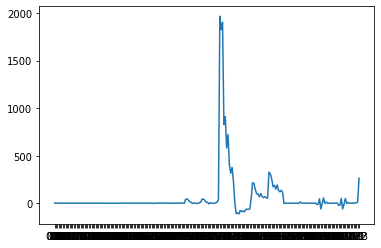

In [21]:
ipd.display(echonest['echonest', 'temporal_features'].head())
x = echonest.loc[2, ('echonest', 'temporal_features')]
plt.plot(x);

### 3.2 Features like MFCCs are discriminant

In [22]:
small

track_id    album                                                    \
              comments        date_created date_released        engineer   
0           2        0 2008-11-26 01:44:45    2009-01-05             NaN   
1           5        0 2008-11-26 01:44:45    2009-01-05             NaN   
2          10        0 2008-11-26 01:45:08    2008-02-06             NaN   
3         140        1 2008-11-26 01:49:59    2007-05-22             NaN   
4         141        0 2008-11-26 01:49:57    2009-01-16             NaN   
...       ...      ...                 ...           ...             ...   
7995   154308        0 2017-03-05 04:57:38    2017-03-05             NaN   
7996   154309        0 2017-03-05 04:57:38    2017-03-05             NaN   
7997   154413        0 2017-03-07 18:44:11           NaT  Ernie Indradat   
7998   154414        0 2017-03-07 18:44:11           NaT  Ernie Indradat   
7999   155066        0 2017-03-24 19:40:34    2017-03-24        JBlanked   

                                                                          \
     favorites     id                                        information   
0            4      1                                            <p></p>   
1            4      1                                            <p></p>   
2            4      6                                                NaN   
3            1     61  <p>Alec K. Redfearn &amp; The Eyesores: Ellen ...   
4            1     60  <p>A full ensamble of strings, drums, electron...   
...        ...    ...                                                ...   
7995         0  22780                                                NaN   
7996         0  22780                                                NaN   
7997         0  22789  <p>A live performance at WFMU for Dark Night o...   
7998         0  22789  <p>A live performance at WFMU for Dark Night o...   
7999         1  22899  <p>Hip Hop, Old School type beat 2017, Trap Mu...   

                                              ...  \
     listens                        producer  ...   
0       6073                             NaN  ...   
1       6073                             NaN  ...   
2      47632                             NaN  ...   
3       1300  Alec K. Refearn, Rob Pemberton  ...   
4       1304                             NaN  ...   
...      ...                             ...  ...   
7995   22334                         Fleslit  ...   
7996   22334                         Fleslit  ...   
7997    3777                   Julie Bennack  ...   
7998    3777                   Julie Bennack  ...   
7999    4524                        JBlanked  ...   

                                                  track                   \
                                                license listens lyricist   
0     Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
1     Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
2     Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
3     Attribution-Noncommercial-No Derivative Works ...    1299      NaN   
4     Attribution-Noncommercial-No Derivative Works ...     725      NaN   
...                                                 ...     ...      ...   
7995                                        Attribution    2705      NaN   
7996                                        Attribution    3589      NaN   
7997  Creative Commons Attribution-NonCommercial-NoD...     676      NaN   
7998  Creative Commons Attribution-NonCommercial-NoD...     788      NaN   
7999                                        Attribution    1474      NaN   

                                                                          \
     number publisher                                               tags   
0         3       NaN                                                 []   
1         6       NaN                                                 []   
2         1       NaN                       

In [23]:
small = tracks['set', 'subset'] == 'small'


In [24]:
small

track_id
2          True
3         False
5          True
10         True
20        False
          ...  
155316    False
155317    False
155318    False
155319    False
155320    False
Name: (set, subset), Length: 106574, dtype: bool

((2000, 2), (2000,))

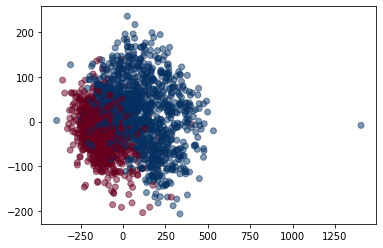

In [25]:
small = tracks['set', 'subset'] == 'small'
genre1 = tracks['track', 'genre_top'] == 'Instrumental'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

X = features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

## 4 Audio

You can load the waveform and listen to audio in the notebook itself.

In [26]:
# filename = utils.get_audio_path(AUDIO_DIR, 2)
# print('File: {}'.format(filename))

# x, sr = librosa.load(filename, sr=None, mono=True)
# print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

# start, end = 7, 17
# ipd.Audio(data=x[start*sr:end*sr], rate=sr)

In [ ]:
directory = 'data/fma_small/000/'
for filename in os.listdir(directory):
    if filename.endswith(".mp3"):
        x, sr = librosa.load(filename, sr=None, mono=True,duration = 30)
        print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

In [70]:
data_dir = 'data/fma_small/000/'
for fname in os.listdir(data_dir):
    full_path = f'{data_dir}{fname}'
    print(full_path)
    # open this full_path for file
    

data/fma_small/000/000010.mp3
data/fma_small/000/000212.mp3
data/fma_small/000/000574.mp3
data/fma_small/000/000825.mp3
data/fma_small/000/000602.mp3
data/fma_small/000/000213.mp3
data/fma_small/000/000207.mp3
data/fma_small/000/000993.mp3
data/fma_small/000/000777.mp3
data/fma_small/000/000005.mp3
data/fma_small/000/000211.mp3
data/fma_small/000/000615.mp3
data/fma_small/000/000204.mp3
data/fma_small/000/000210.mp3
data/fma_small/000/000002.mp3
data/fma_small/000/000200.mp3
data/fma_small/000/000822.mp3
data/fma_small/000/000995.mp3
data/fma_small/000/000997.mp3
data/fma_small/000/000203.mp3
data/fma_small/000/000148.mp3
data/fma_small/000/000821.mp3
data/fma_small/000/000715.mp3
data/fma_small/000/000890.mp3
data/fma_small/000/000853.mp3
data/fma_small/000/000714.mp3
data/fma_small/000/000716.mp3
data/fma_small/000/000676.mp3
data/fma_small/000/000892.mp3
data/fma_small/000/000707.mp3
data/fma_small/000/000459.mp3
data/fma_small/000/000897.mp3
data/fma_small/000/000667.mp3
data/fma_s

In [72]:
data_dir = 'data/fma_small/000/'
for fname in os.listdir(data_dir):
    full_path = f'{data_dir}{fname}'
    x, sr = librosa.load(full_path, sr=None, mono=True,duration = 30)
    # open this full_path for file
    

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 30.00s, 1323000 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 30.00s, 1323000 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 30.00s, 1323000 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 30.00s, 1323000 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 30.00s, 1323000 samples
Duration: 30.00s, 1323000 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 30.00s, 1323000 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 30.00s, 1323000 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 30.00s, 1323000 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples
Duration: 30.00s, 1323000 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 30.00s, 1323000 samples
Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 30.00s, 1323000 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 30.00s, 1323000 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 30.00s, 1323000 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 30.00s, 1323000 samples
Duration: 30.00s, 1323000 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 30.00s, 1323000 samples
Duration: 29.99s, 1322496 samples


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [77]:
from pathlib import Path  # for directory listing
DIRECTORY = Path('data/fma_small/000')
for filename in DIRECTORY.glob('*.mp3'):
    x, sr = librosa.load(full_path, sr=None, mono=True,duration = 30)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PyS

KeyboardInterrupt: 

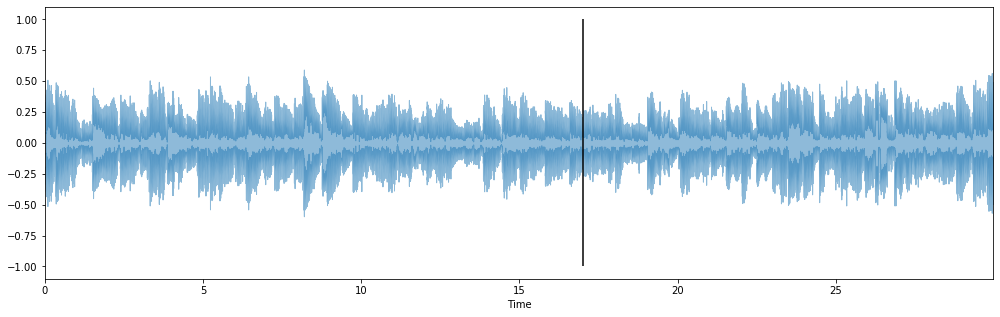

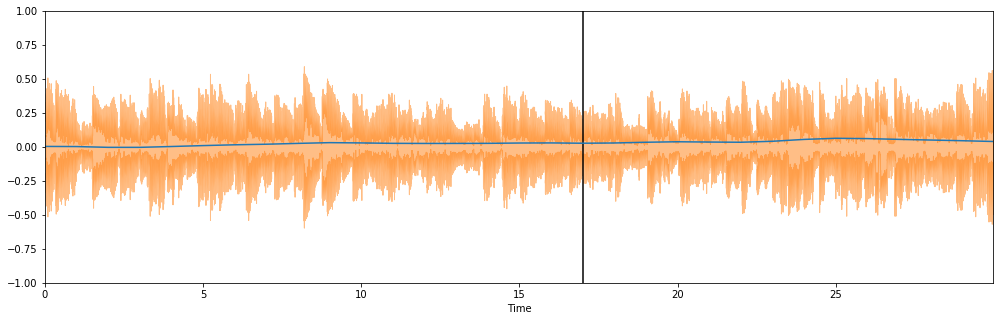

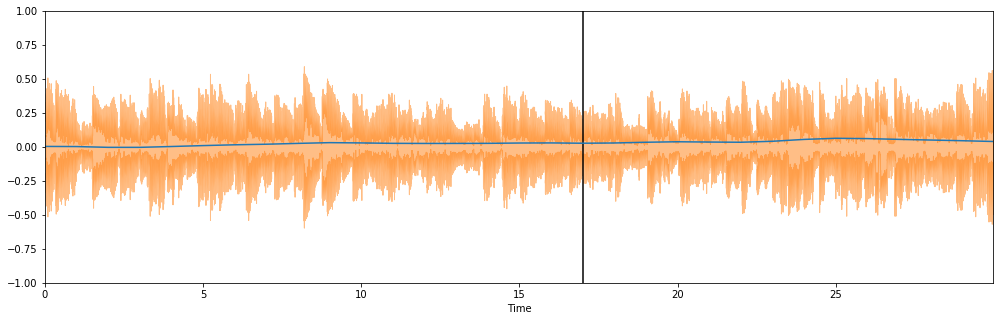

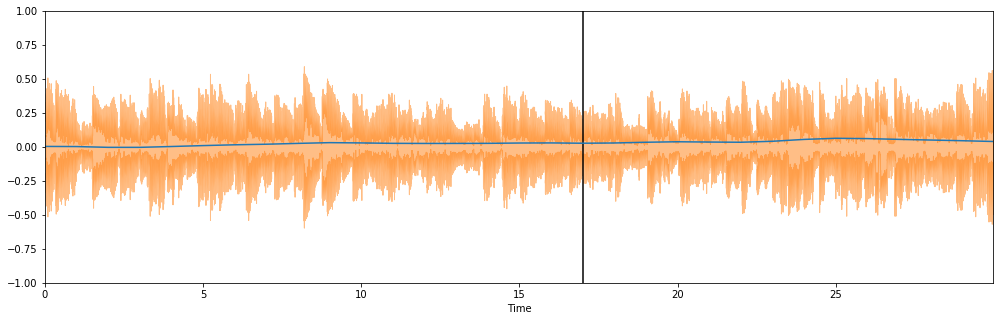

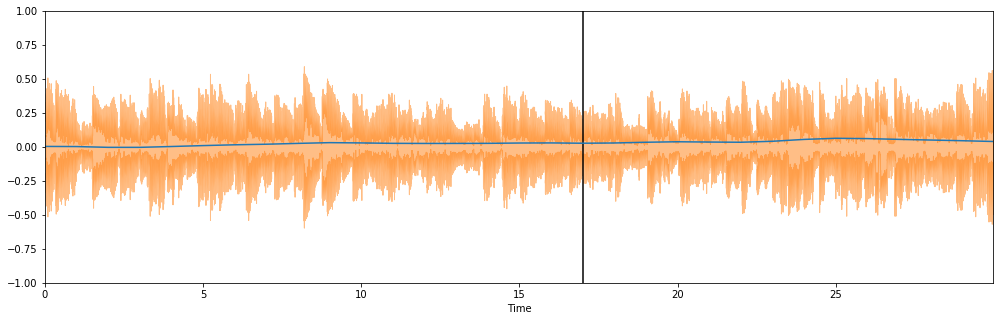

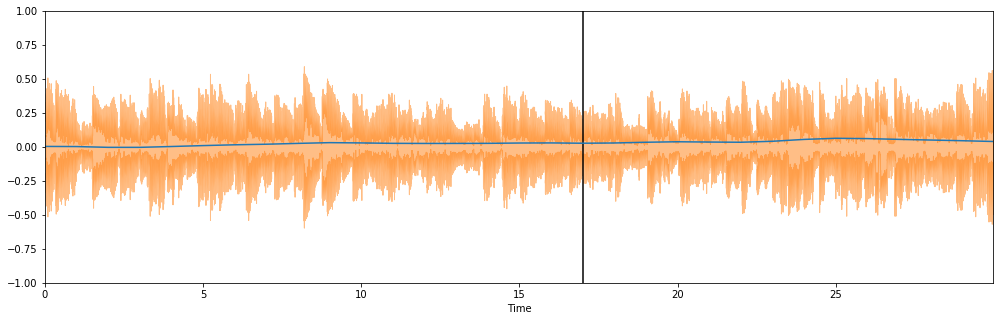

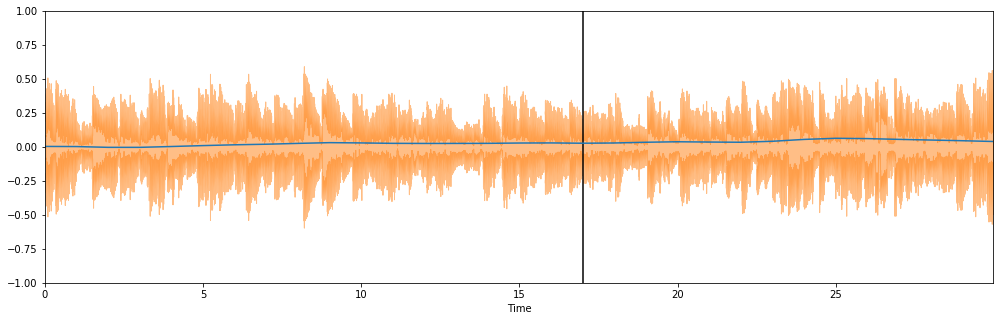

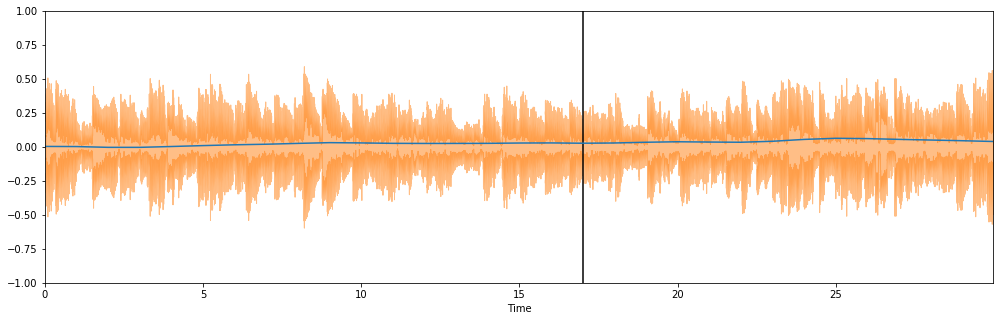

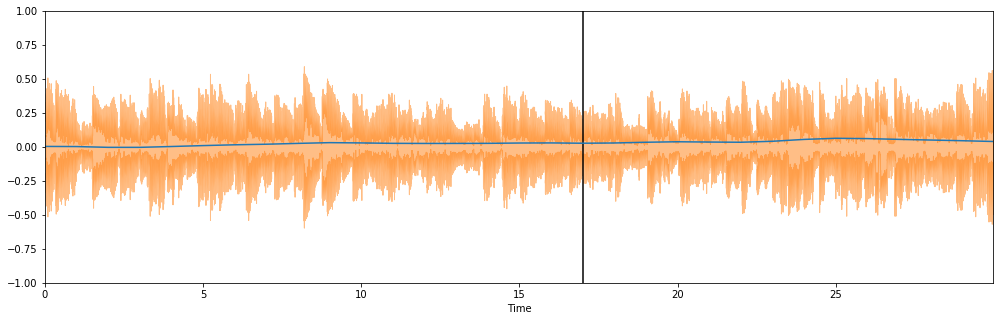

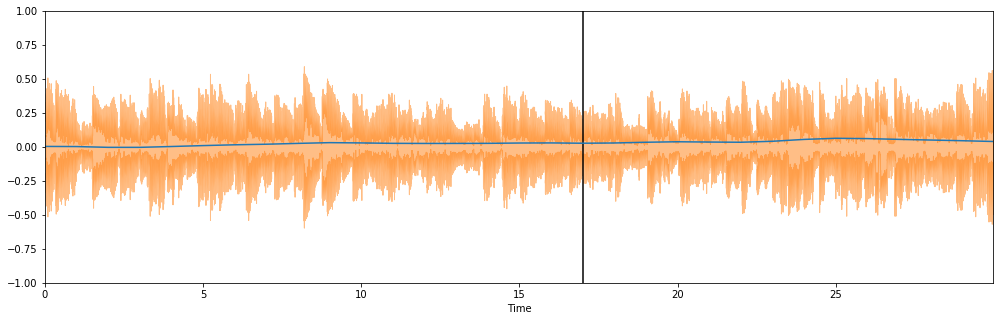

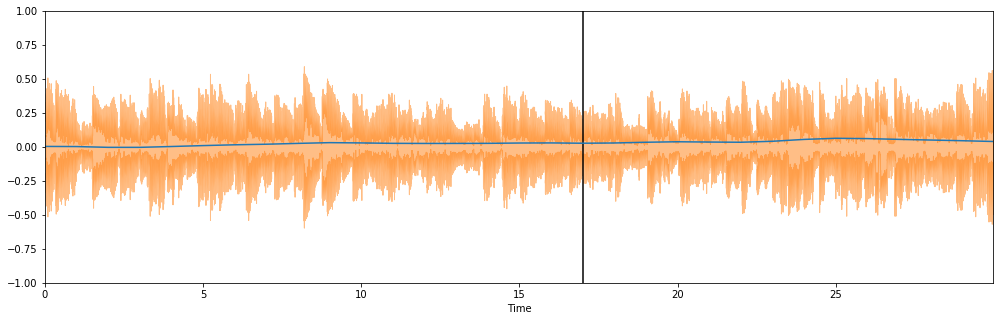

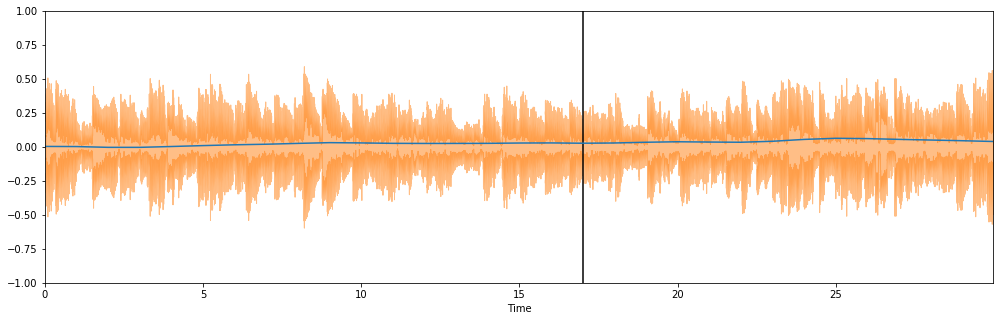

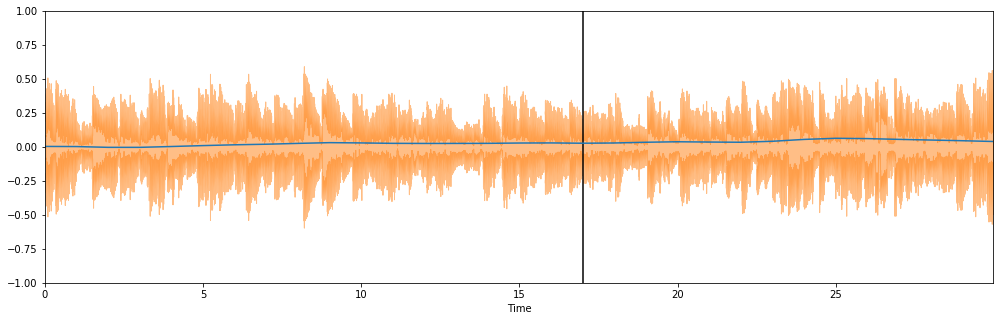

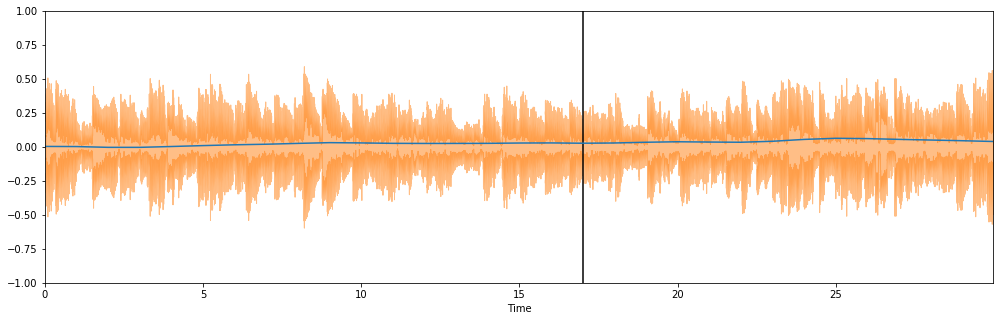

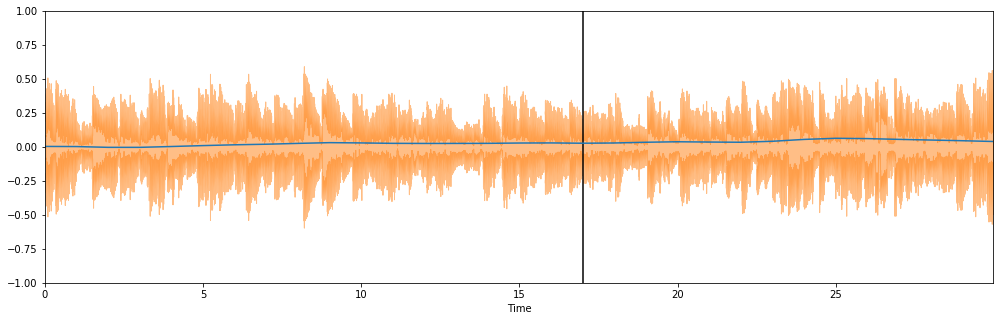

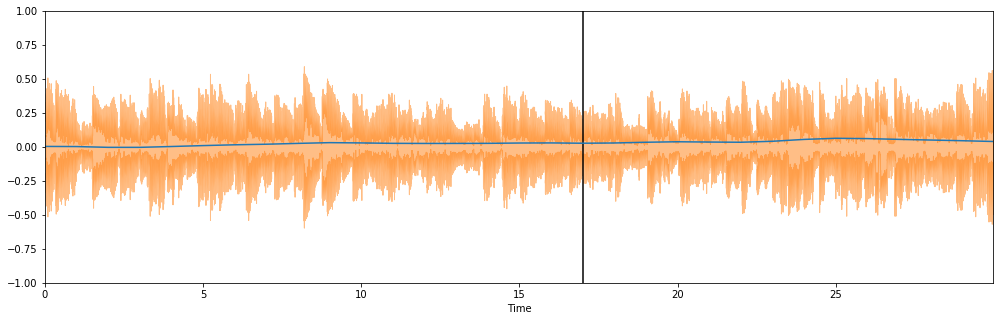

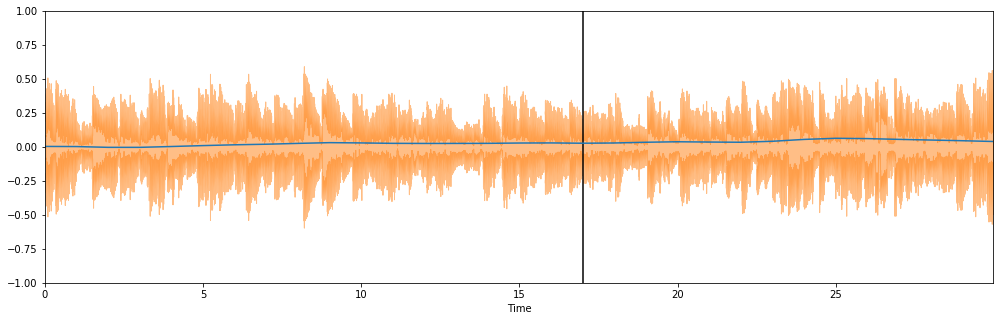

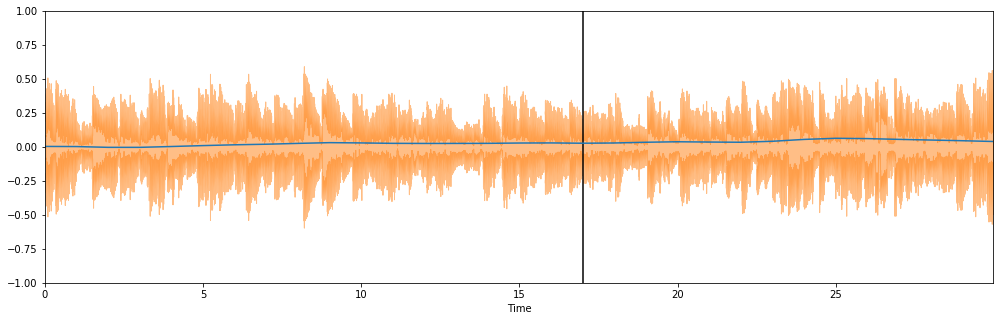

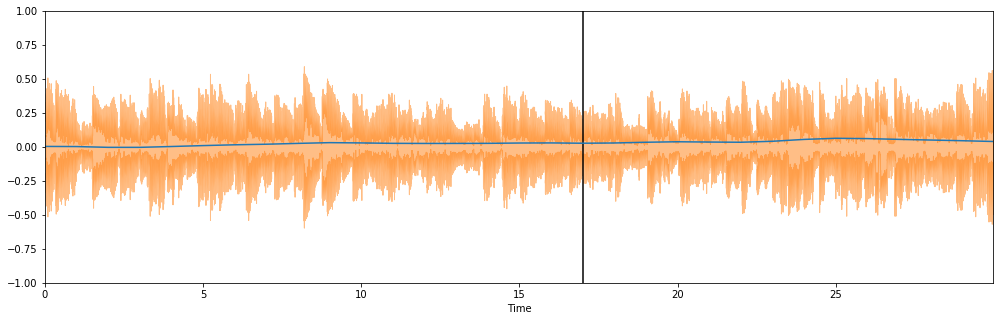

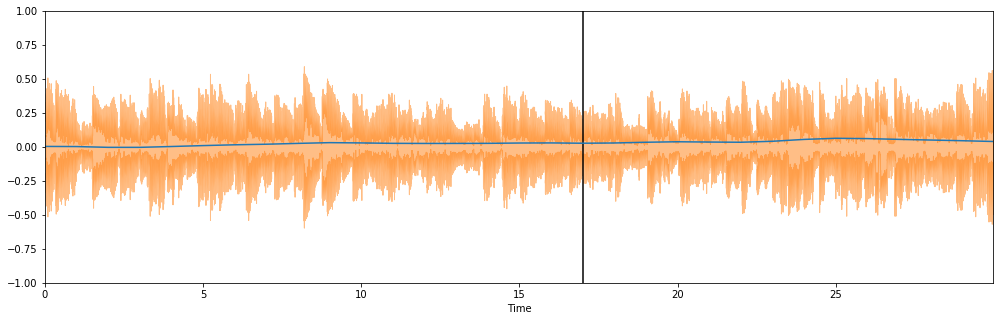

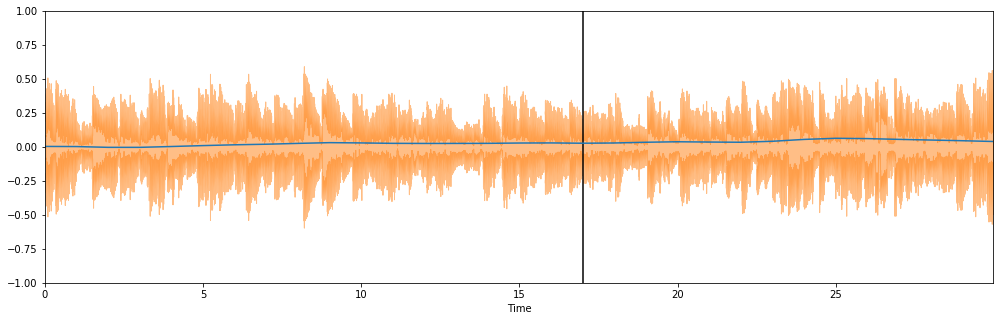

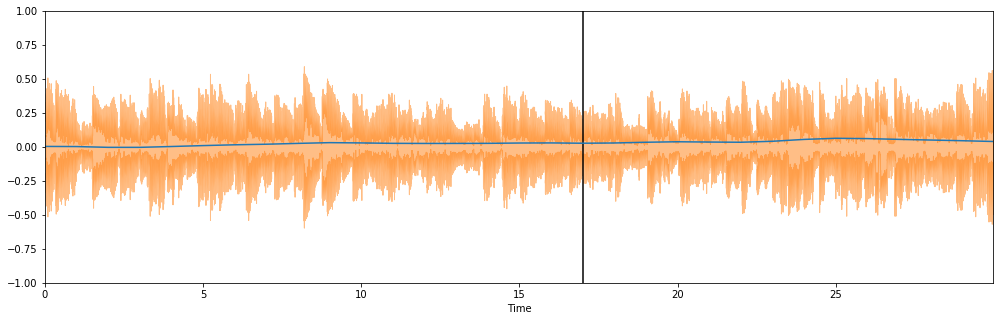

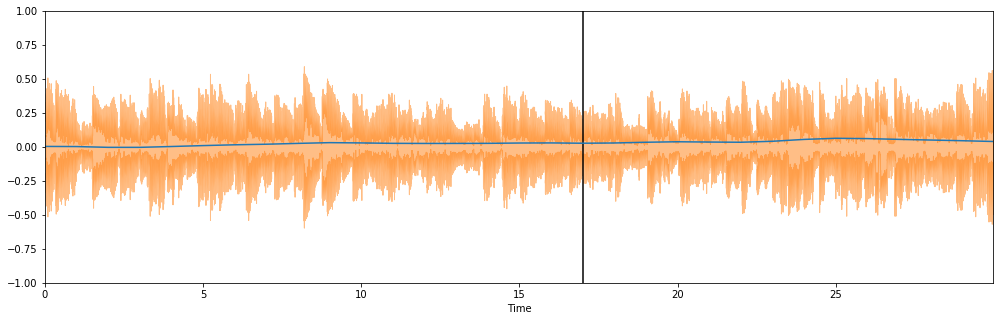

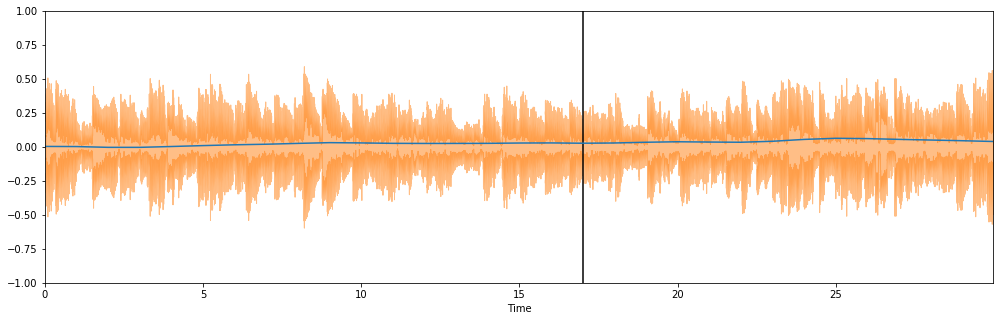

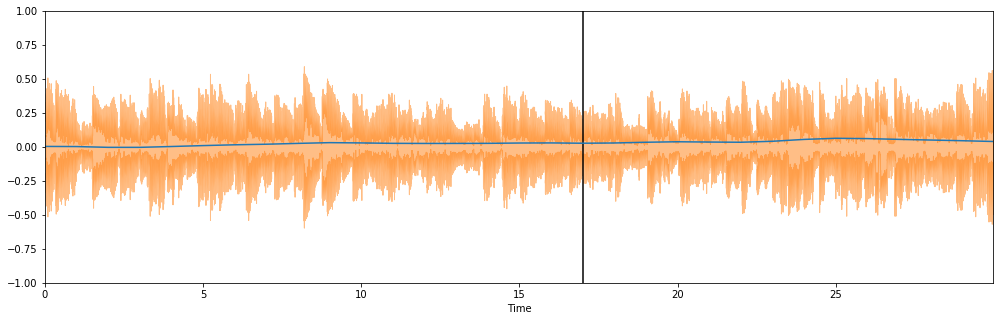

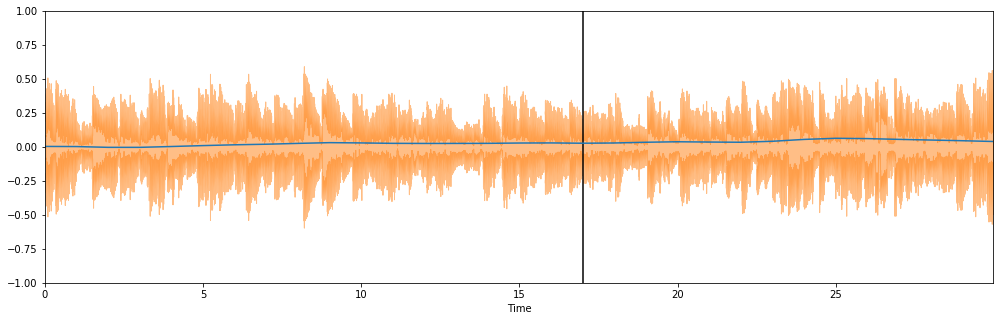

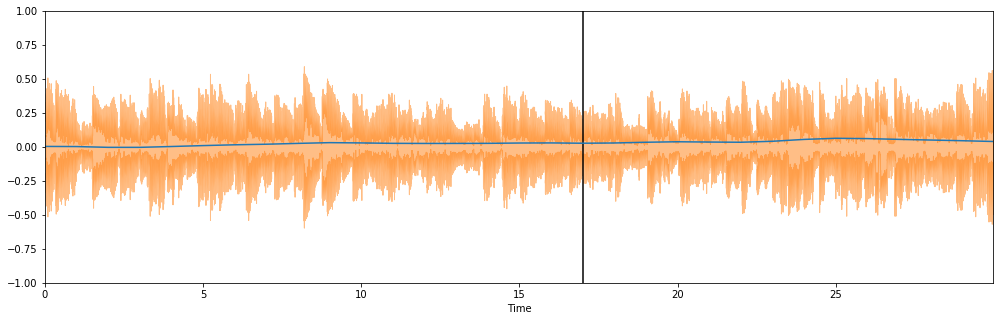

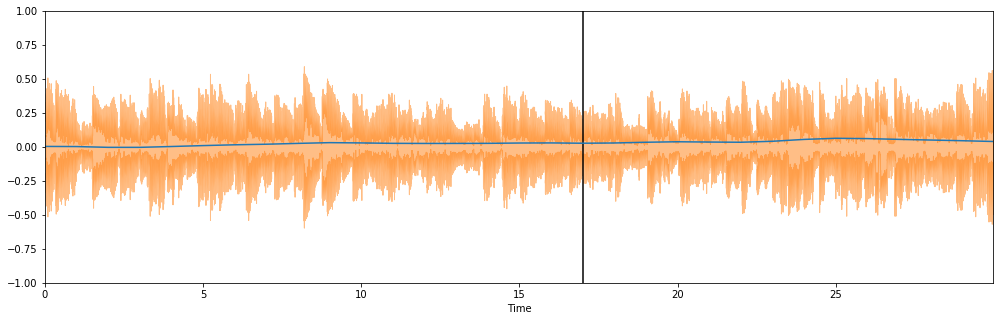

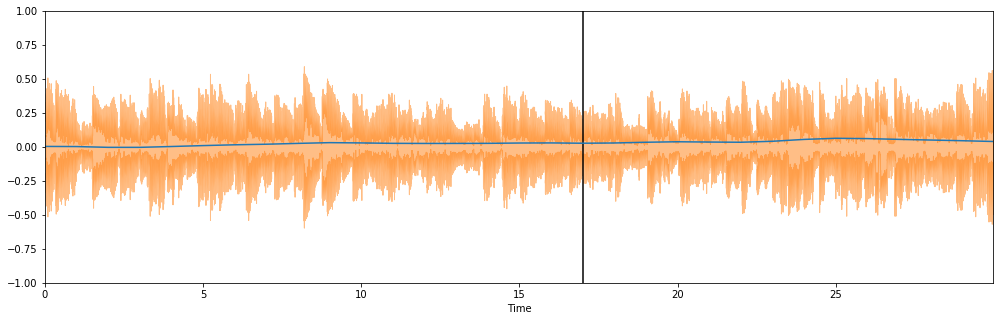

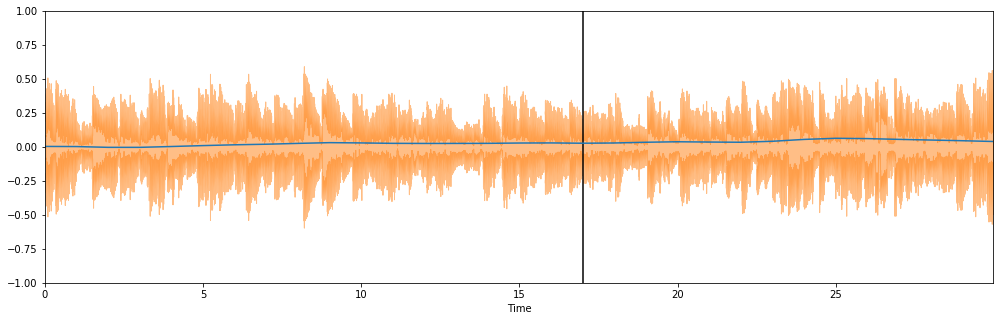

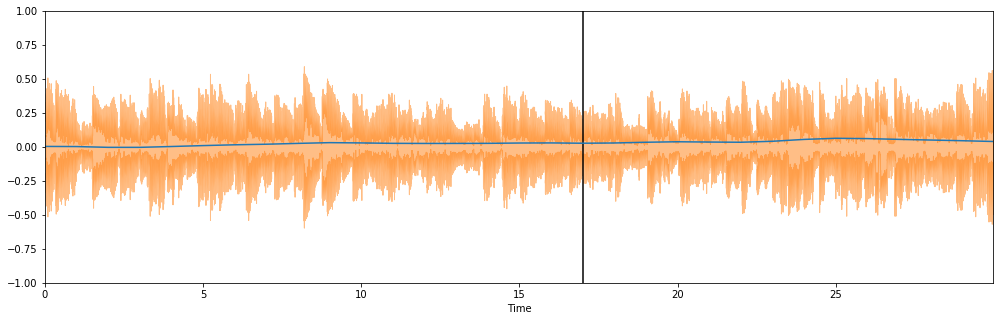

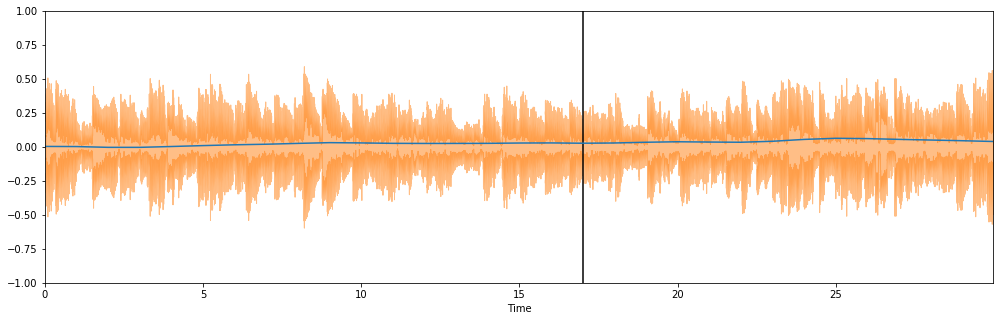

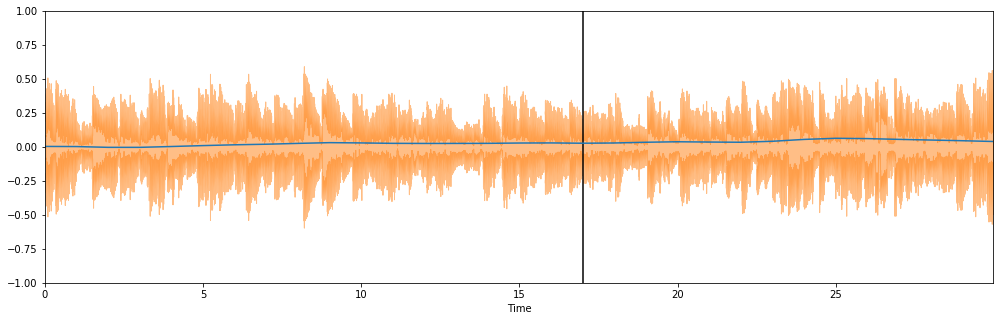

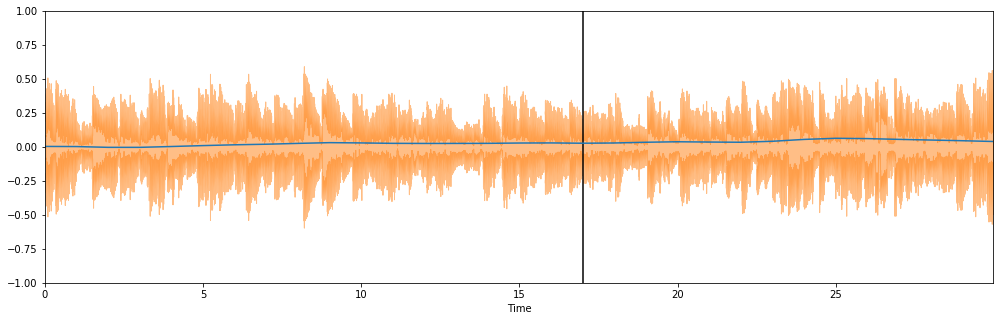

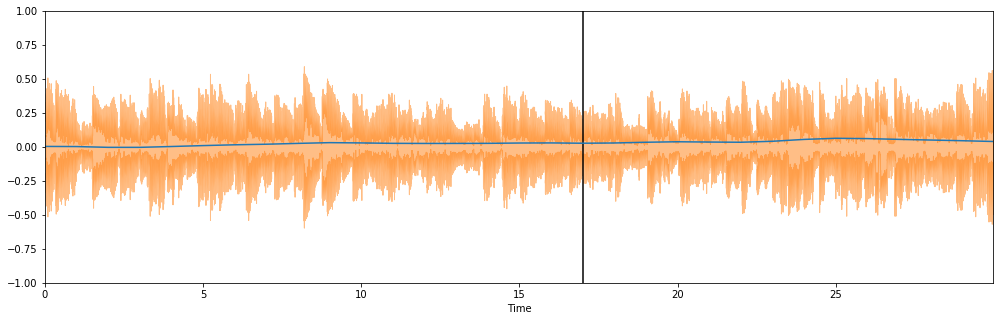

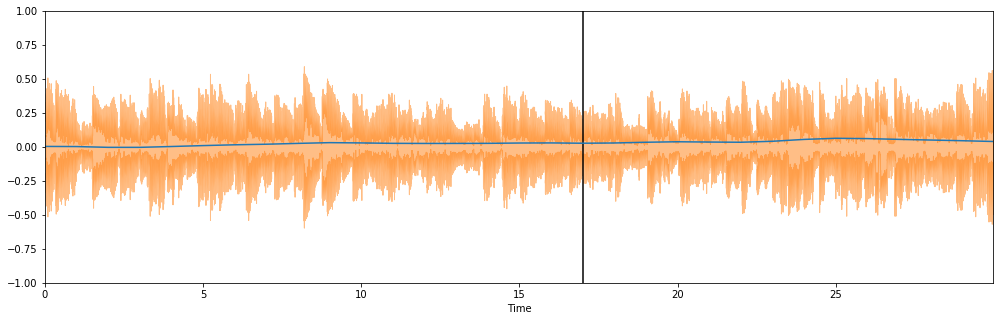

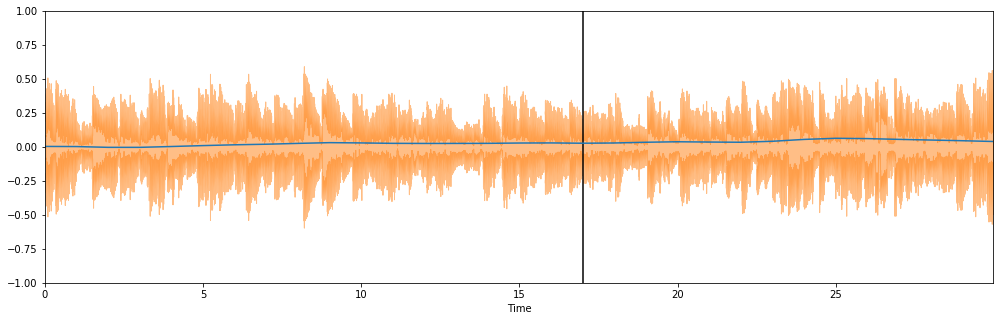

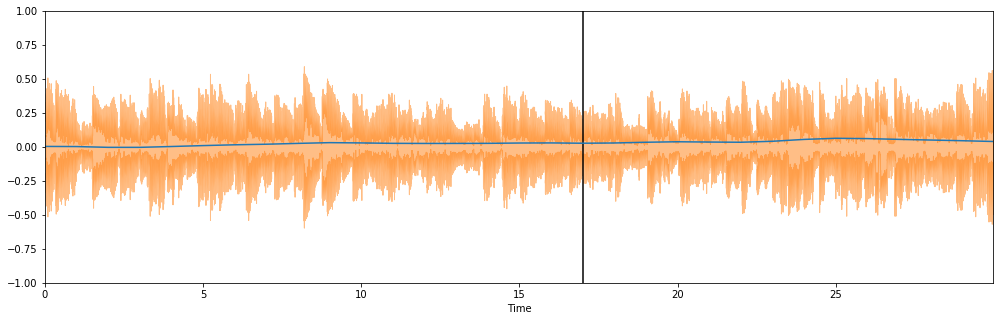

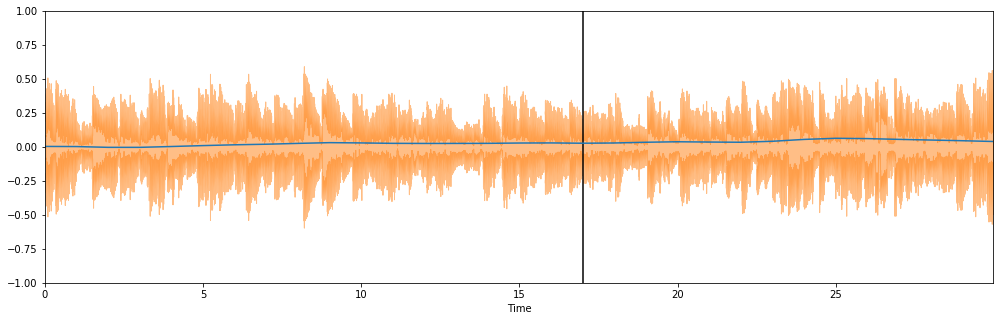

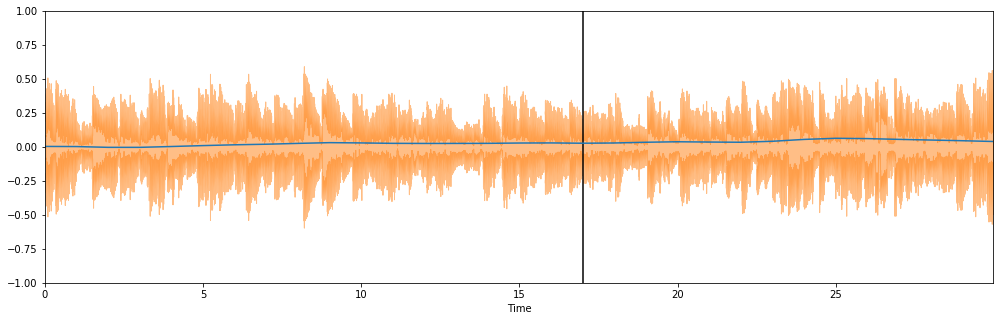

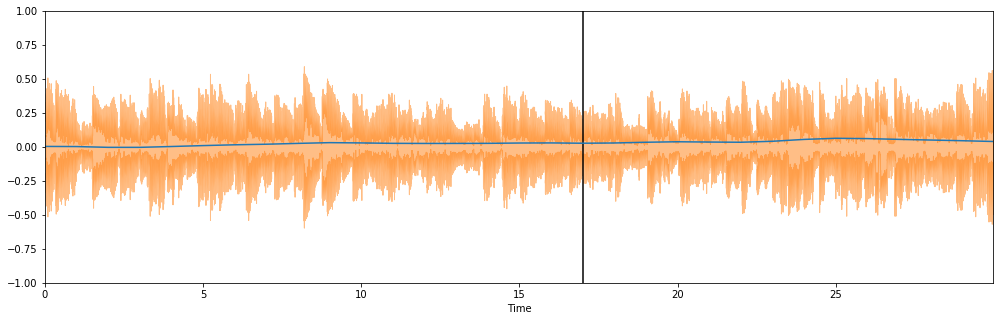

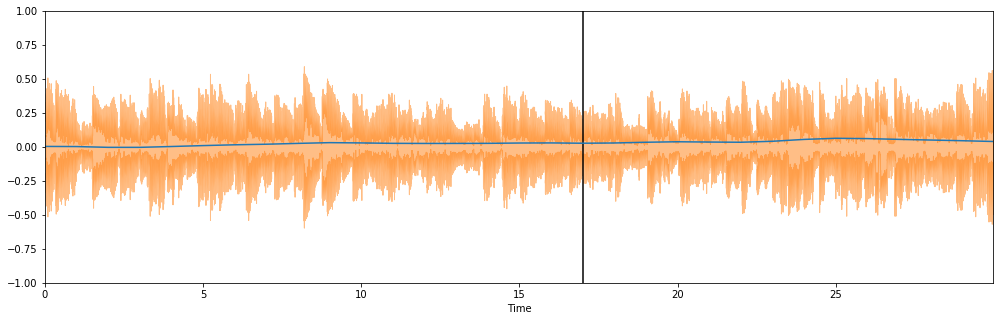

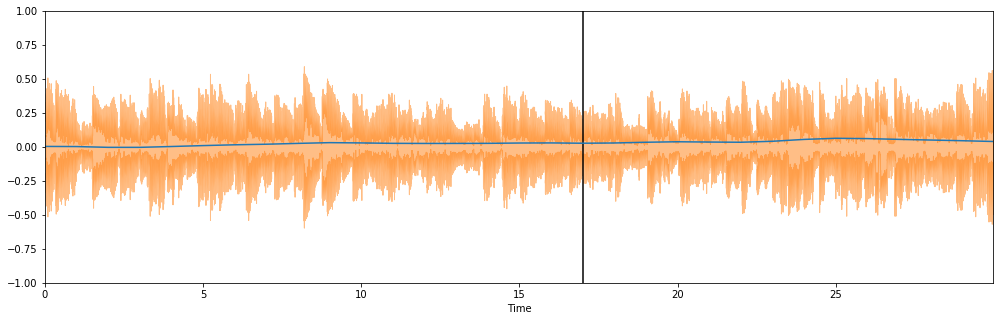

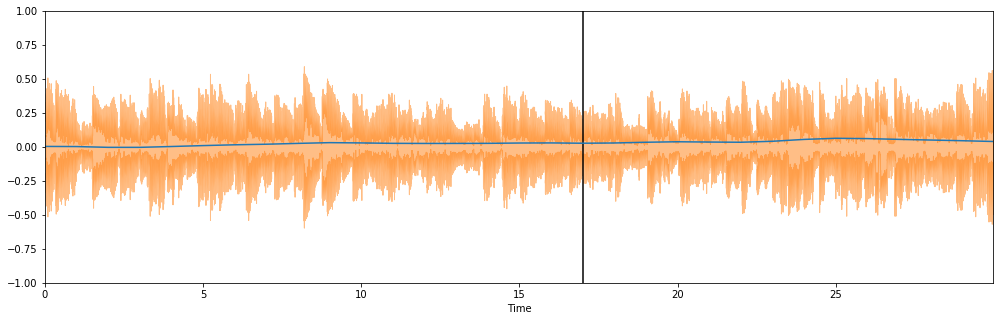

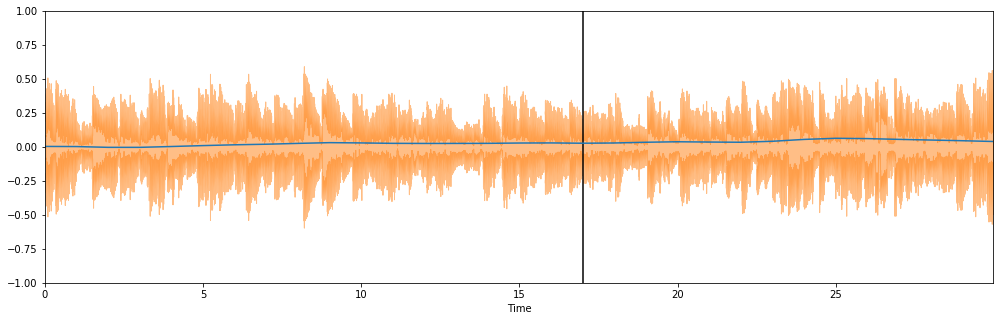

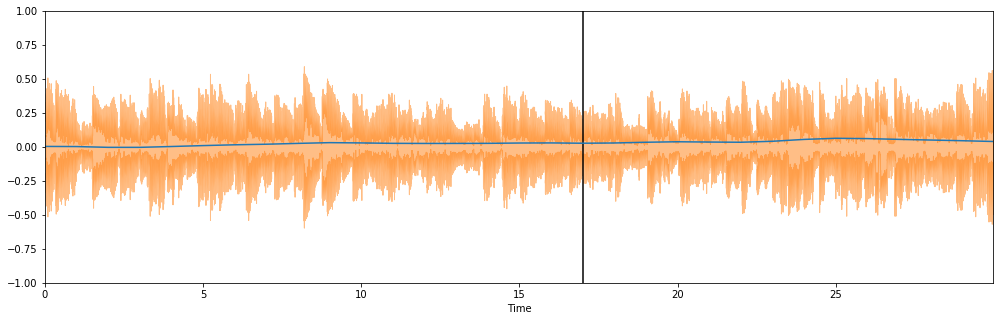

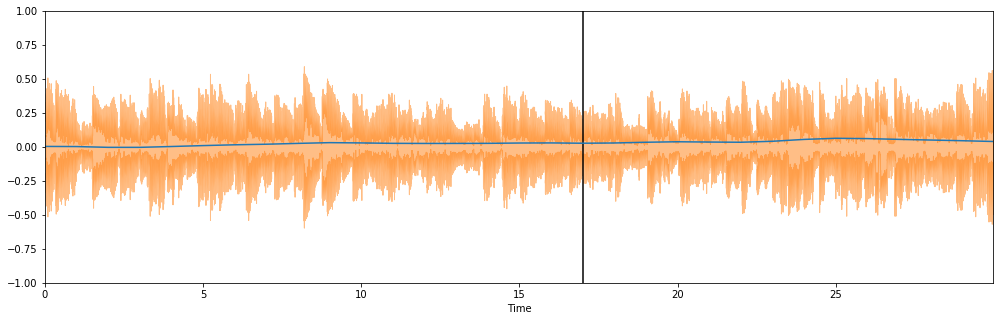

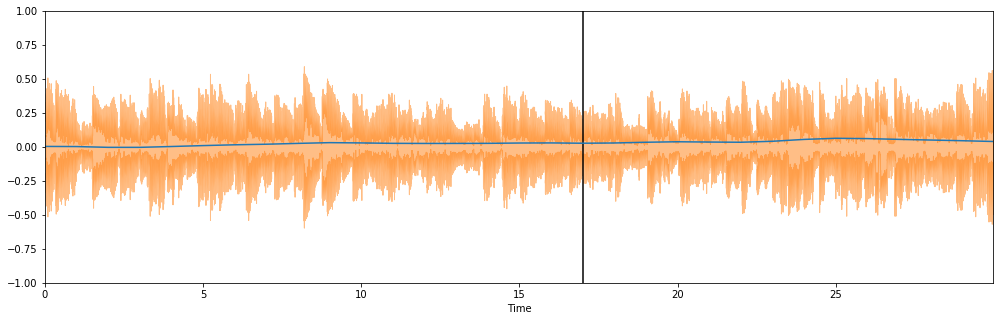

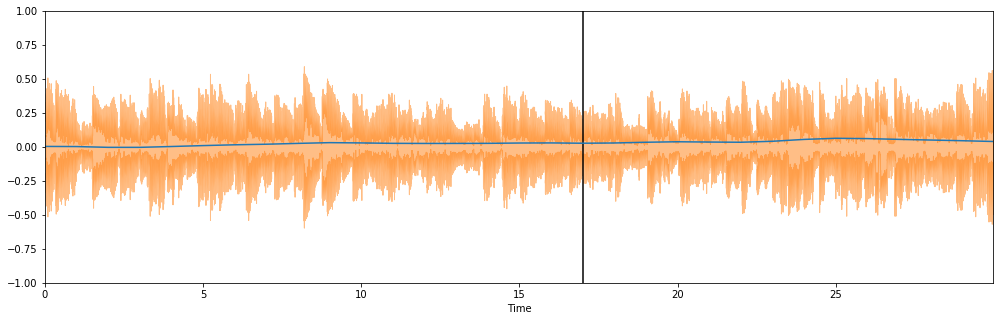

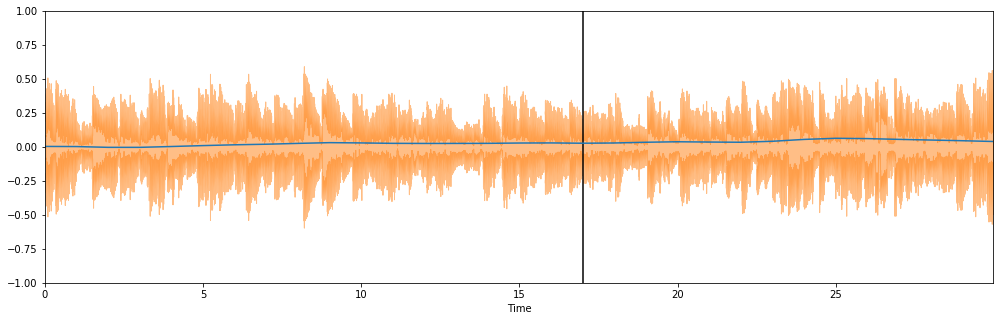

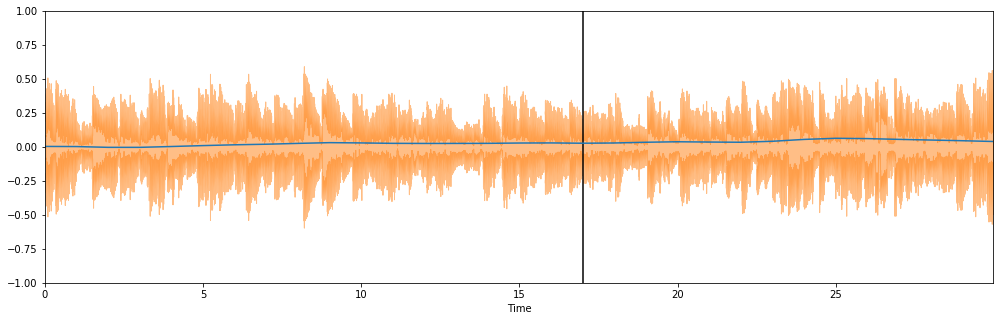

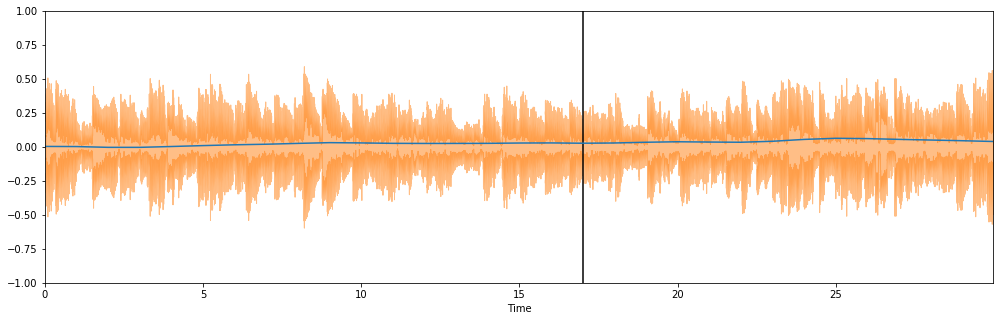

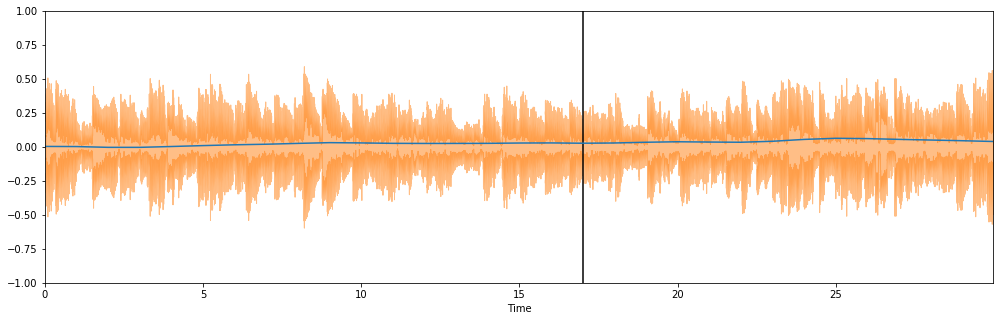

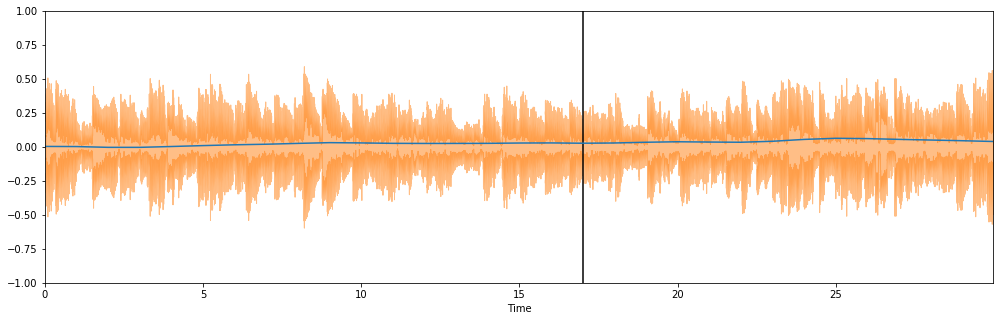

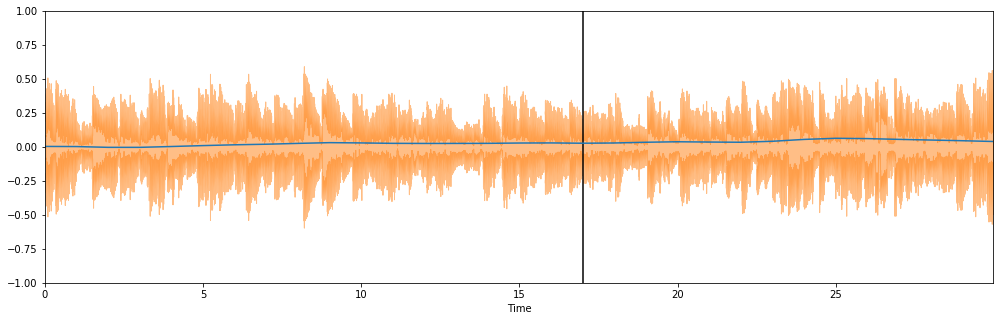

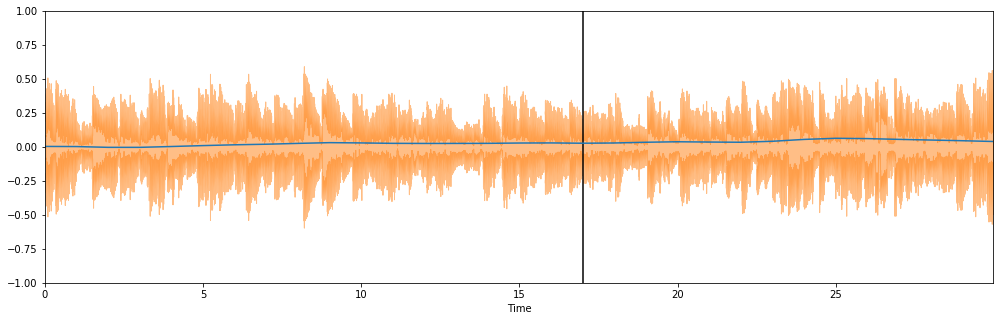

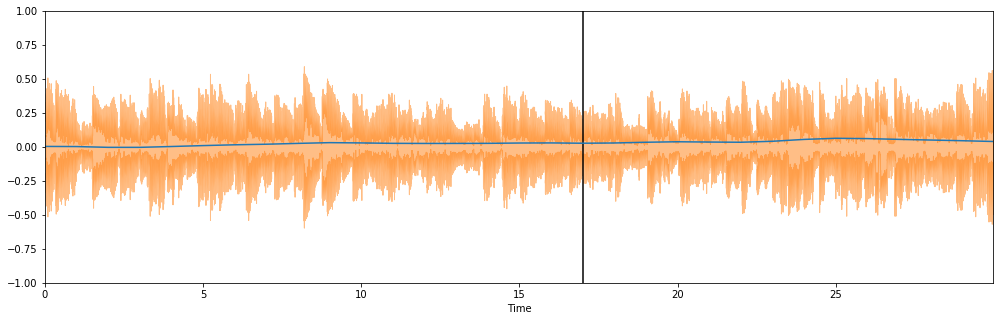

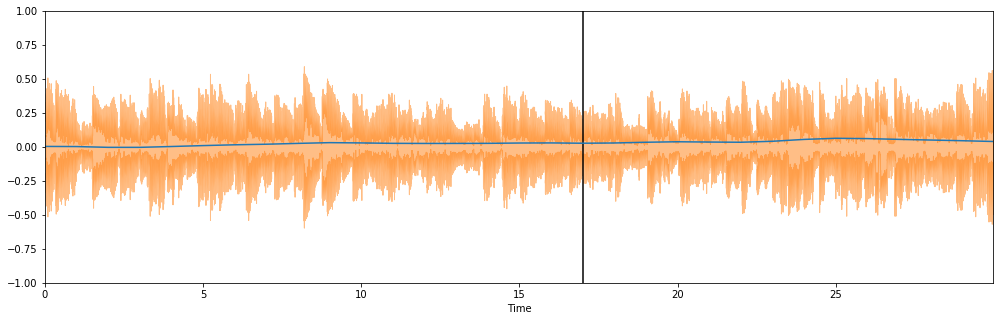

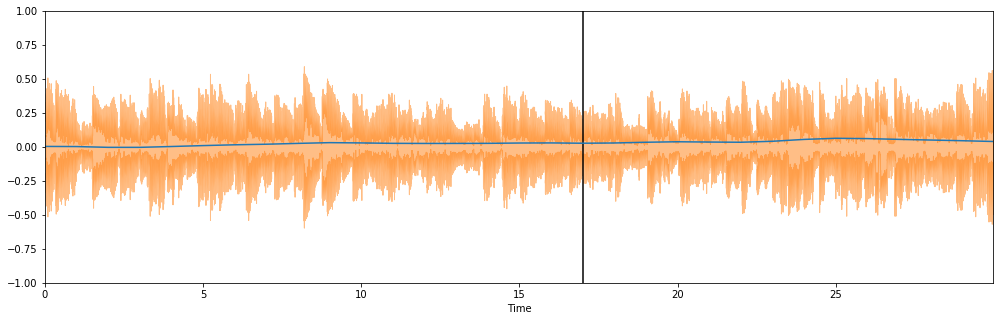

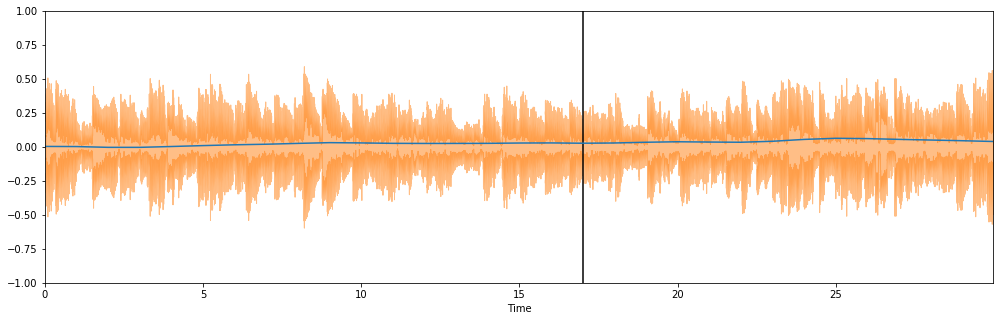

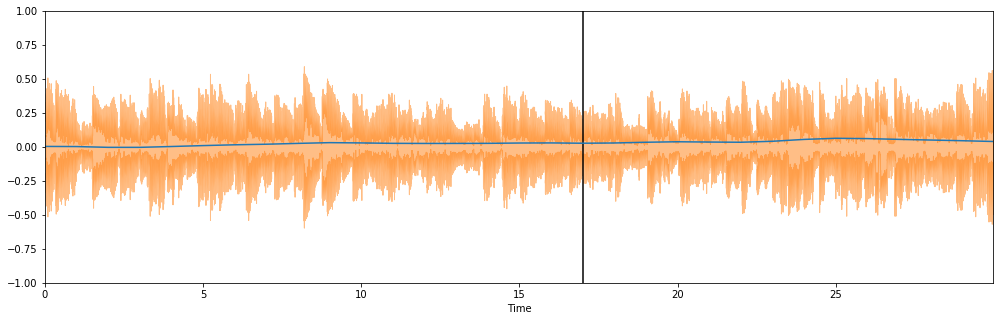

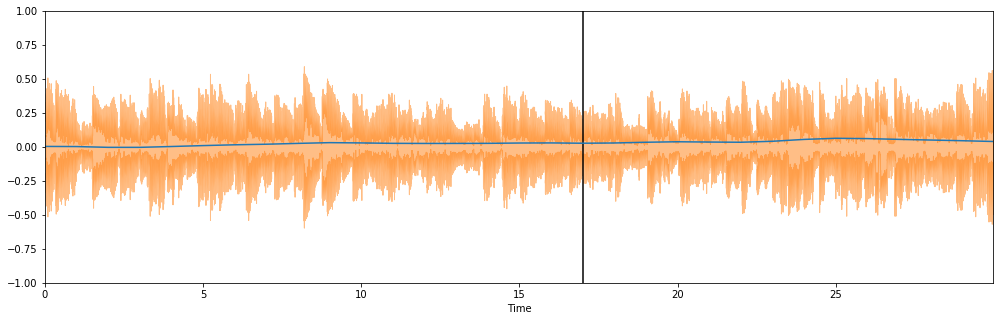

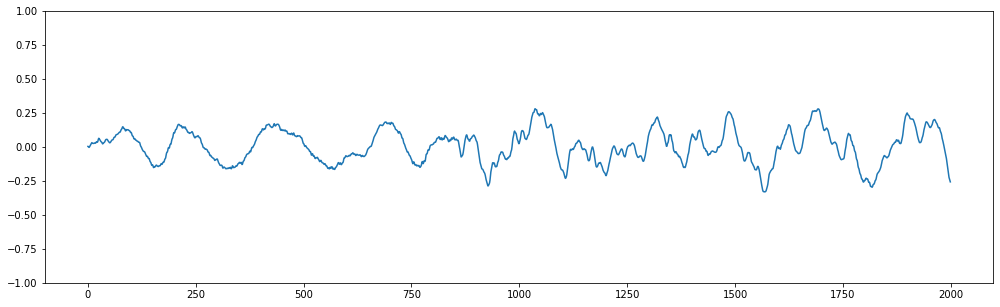

In [86]:
from pathlib import Path  # for directory listing
DIRECTORY = Path('data/fma_small/000')
for filename in DIRECTORY.glob('*.mp3'):
    librosa.display.waveplot(librosa.load(full_path, sr=None, mono=True,duration = 30)[0],
                             librosa.load(full_path, sr=None, mono=True,duration = 30)[1], alpha=0.5);
    plt.vlines([start, end], -1, 1)
    start = len(x) // 2
    plt.figure()
    plt.plot(x[start:start+2000])
    plt.ylim((-1, 1));

In [76]:
filename = 'data/fma_small/000/000010.mp3'
x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))
start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Duration: 29.99s, 1322496 samples


And use [librosa](https://github.com/librosa/librosa) to compute spectrograms and audio features.

In [85]:
filename = 'data/fma_small/000/000010.mp3'
librosa.load(full_path, sr=None, mono=True,duration = 30)[1]

44100

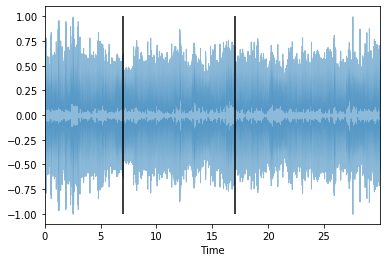

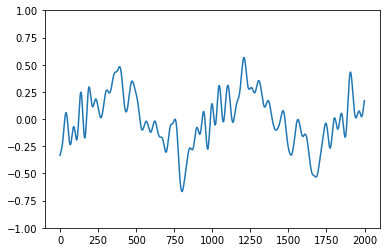

In [29]:
librosa.display.waveplot(x, sr, alpha=0.5);
plt.vlines([start, end], -1, 1)
start = len(x) // 2
plt.figure()
plt.plot(x[start:start+2000])
plt.ylim((-1, 1));

In [30]:
librosa.amplitude_to_db

<function librosa.core.spectrum.amplitude_to_db(S, ref=1.0, amin=1e-05, top_db=80.0)>

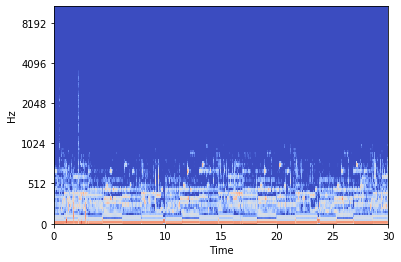

In [31]:
stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
log_mel = librosa.amplitude_to_db(mel)

librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel');

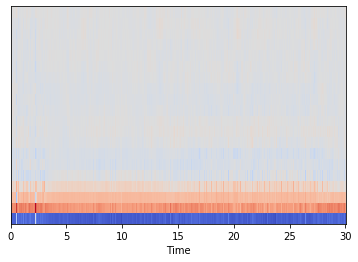

In [32]:
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = skl.preprocessing.StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis='time');

In [33]:
mfcc

array([[-3.41688180e+00, -3.39638925e+00, -3.43171668e+00, ...,
        -3.29095268e+00, -3.44312692e+00, -3.77547646e+00],
       [ 2.56806827e+00,  2.60503674e+00,  2.54776001e+00, ...,
         2.68599415e+00,  2.55964899e+00,  2.07870317e+00],
       [ 1.20812547e+00,  1.19754016e+00,  1.20483971e+00, ...,
         1.28462672e+00,  1.19119000e+00,  1.12935770e+00],
       ...,
       [-1.15487136e-01, -1.33437276e-01, -8.64682570e-02, ...,
         1.61751709e-03, -2.59644212e-03,  6.39200117e-03],
       [-7.12716812e-03, -5.93503900e-02, -5.88209741e-02, ...,
         2.21971311e-02,  7.16413409e-02,  8.16012844e-02],
       [ 5.66112176e-02,  1.33408662e-02,  1.58920437e-02, ...,
         7.60766193e-02,  1.57638460e-01,  1.53354868e-01]], dtype=float32)

## 5 Genre classification

### 5.1 From features

In [34]:
small

track_id
2          True
3         False
5          True
10         True
20        False
          ...  
155316    False
155317    False
155318    False
155319    False
155320    False
Name: (set, subset), Length: 106574, dtype: bool

In [50]:
small = tracks['set', 'subset'] == 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
140 features, 8 classes


In [51]:
# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = skl.svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 46.38%


In [52]:
clf.score(X_train, y_train)

0.758125

In [44]:
from sklearn.model_selection import GridSearchCV
#Create a dictionary called param_grid and fill out some parameters for kernels, C and gamma

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
# Create a GridSearchCV object and fit it to the training data

grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

#Find the optimal parameters

print(grid.best_estimator_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   7.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   7.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   7.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   8.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   7.8s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   5.7s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   5.9s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   5.9s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=   7.4s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   9.4s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   8.5s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   8.7s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   8.3s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   8.7s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] ........................ C=1, gamma=1, kernel=poly, total=   6.1s
[CV] C=1, gamma=1, kernel=poly .......................................
[CV] .

[CV] ................. C=1, gamma=0.001, kernel=sigmoid, total=   5.9s
[CV] C=1, gamma=0.001, kernel=sigmoid ................................
[CV] ................. C=1, gamma=0.001, kernel=sigmoid, total=   5.8s
[CV] C=1, gamma=0.001, kernel=sigmoid ................................
[CV] ................. C=1, gamma=0.001, kernel=sigmoid, total=   5.3s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   8.3s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   8.4s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   8.3s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........................ C=10, gamma=1, kernel=rbf, total=   8.3s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] .

[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total=   4.3s
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total=   4.2s
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total=   4.2s
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total=   4.2s
[CV] C=10, gamma=0.001, kernel=sigmoid ...............................
[CV] ................ C=10, gamma=0.001, kernel=sigmoid, total=   4.8s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=   9.2s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] ....................... C=100, gamma=1, kernel=rbf, total=   8.9s
[CV] C=100, gamma=1, kernel=rbf ......................................
[CV] .

[CV] .................. C=100, gamma=0.001, kernel=poly, total=   6.3s
[CV] C=100, gamma=0.001, kernel=poly .................................
[CV] .................. C=100, gamma=0.001, kernel=poly, total=   6.4s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   4.2s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   4.0s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   3.7s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   3.9s
[CV] C=100, gamma=0.001, kernel=sigmoid ..............................
[CV] ............... C=100, gamma=0.001, kernel=sigmoid, total=   4.2s


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 24.9min finished


SVC(C=10, gamma=0.01)


In [45]:
print(grid.best_estimator_)

SVC(C=10, gamma=0.01)


In [46]:
print(grid.best_estimator_

SVC(C=10, gamma=0.01)

In [53]:
print(grid.best_params_)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [ ]:
C': 10, 'gamma': 0.01, 'kernel': 'rbf'

In [49]:
# Be sure training samples are shuffled.
# X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)



Accuracy: 44.75%


In [54]:
# Support vector classification.
clf2 = skl.svm.SVC(C=10,gamma=0.01)
clf2.fit(X_train, y_train)
score = clf2.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 44.75%


In [326]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [327]:

genre_list = tracks['track', 'genre_top']
encoder = LabelEncoder()
tracks['track', 'genre_top'] = encoder.fit_transform(genre_list)


TypeError: Encoders require their input to be uniformly strings or numbers. Got ['float', 'str']

In [328]:
y

array([3, 3, 6, ..., 6, 6, 3])

In [329]:
# scaler = StandardScaler()
# X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [353]:
smalldf  = tracks.loc[tracks['subset']=='small']

In [354]:
encoder = LabelEncoder()

smalldf['labels'] = encoder.fit_transform(smalldf['track', 'genre_top'])

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [355]:
smalldf['labels']

track_id
2         3
5         3
10        6
140       2
141       2
         ..
154308    3
154309    3
154413    6
154414    6
155066    3
Name: labels, Length: 8000, dtype: int64

In [356]:
y_train = smalldf.loc[train, ('labels')]
y_test = smalldf.loc[test, ('labels')]
y_val = y_test = smalldf.loc[val, ('labels')]


In [357]:
y_train.value_counts()

7    800
3    800
6    800
2    800
5    800
1    800
4    800
0    800
Name: labels, dtype: int64

In [358]:
y_test.value_counts()

7    100
6    100
5    100
4    100
3    100
2    100
1    100
0    100
Name: labels, dtype: int64

In [368]:
train = smalldf['set', 'split'] == 'training'
val = smalldf['set', 'split'] == 'validation'
test = smalldf['set', 'split'] == 'test'


X_train = features.loc[small & train, 'mfcc']
X_test = features.loc[small & test, 'mfcc']
X_val = features.loc[small & val, 'mfcc']
print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

6400 training examples, 800 testing examples
140 features, 8 classes


In [369]:
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 2.02407870e+00,  7.28341156e-01,  2.04241274e+00, ...,
        -5.21931263e-01, -8.24199676e-01, -7.80570294e-01],
       [ 1.40072301e-02, -3.89110770e-01, -2.80515927e-01, ...,
         2.49215243e-01,  1.43903422e-01,  7.42925519e-01],
       [-3.27751541e-02, -4.64044606e-01,  1.57717431e-01, ...,
         4.74054870e-02, -6.77014218e-03, -1.44250996e-01],
       ...,
       [-3.04122154e-01, -4.97753390e-01, -8.27489341e-06, ...,
         7.09121936e-01,  2.35810789e+00,  1.56903540e+00],
       [-2.59806394e-01, -2.07064389e-01,  1.37721511e-01, ...,
        -4.98516891e-01,  1.47795198e-01,  2.76447211e-01],
       [-2.95374053e-01, -7.25148255e-01,  3.32040621e-01, ...,
         4.31275266e-02, -1.65205994e-01,  8.37615946e-01]])

In [370]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(140, activation='relu', input_shape=(X_train.shape[1],)))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(8, activation='softmax'))



In [371]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [372]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128)

Epoch 1/20
6400/6400 [==============================] - 1s 92us/step - loss: 2.1105 - acc: 0.1225
Epoch 2/20
6400/6400 [==============================] - 0s 17us/step - loss: 2.0476 - acc: 0.1895
Epoch 3/20
6400/6400 [==============================] - 0s 18us/step - loss: 2.0131 - acc: 0.2186
Epoch 4/20
6400/6400 [==============================] - 0s 18us/step - loss: 1.9735 - acc: 0.2470
Epoch 5/20
6400/6400 [==============================] - 0s 18us/step - loss: 1.9254 - acc: 0.2784
Epoch 6/20
6400/6400 [==============================] - 0s 18us/step - loss: 1.8721 - acc: 0.3103
Epoch 7/20
6400/6400 [==============================] - 0s 17us/step - loss: 1.8108 - acc: 0.3325
Epoch 8/20
6400/6400 [==============================] - 0s 17us/step - loss: 1.7414 - acc: 0.3687
Epoch 9/20
6400/6400 [==============================] - 0s 18us/step - loss: 1.6594 - acc: 0.4113
Epoch 10/20
6400/6400 [==============================] - 0s 18us/step - loss: 1.5912 - acc: 0.4381
Epoch 11/20
6400/64

In [373]:
test_loss, test_acc = model.evaluate(X_test,y_test)

print('test_acc: ',test_acc)

800/800 [==============================] - 0s 203us/step
test_acc:  0.13625


### 5.2 From audio